<a href="https://colab.research.google.com/github/pintu1803/Fake_News_Detection_Hybrid_cnn-rnn/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection Using Hybrid CNN-RNN model.
Team project:
1. Pintu (181CO139) 
2. Akshay Dhayal (181CO105)

In the guidance of Dr. M Venkatesan (CSE Prof. @NITK)

Note: Run 1st and 2nd cell first, then comment them out and run all cells.

# Mount Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Download the GloVe: Pretrained word embedding model. It is developed by Standford NLP group. It is faster to compute than Word2Vec. Use: Dimensionality reduction

In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# Load and split the data

In [3]:
#23/03/2021
#Pintu 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd

dataset=pd.read_csv('/content/drive/MyDrive/fake-news/train.csv')

#remove the missing data.
dataset=dataset.dropna()

n=int(0.8 * len(dataset))
x=dataset['text'].values[:n]
y=dataset['label'].values[:n]

x_valid=dataset['text'].values[n:]
y_valid=dataset['label'].values[n:]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=1000)

print(type(x), type(y)) 
print(type(x_valid), type(y_valid))
print(type(x_train), type(x_test))
print(type(y_train), type(y_test))
#those ending with .values are ndarray.
#train_test_split output has same type as of input.

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Build Vocabulary 

tokenizer is the object created, of Tokenizer class. 
num_words=1,40,000, it means we want only 1st 50k words from entire vocabulary to be used.
->> tokenizer.fit_on_texts(x_train)
action: 1) it collects all words from training data and counts the frequency of each word in that corpus.
2) All words are arranged in descending order. ie. most occured word is placed at index=1, 0 is not used as index.
3) Indexes are assigned to all unique words, but out of them only 1st 50K will be used.
4) This is stored in dictionary=word_index

->> x_train = tokenizer.texts_to_sequences(x_train)
action: All texts are converted in sequence of integers. Means that the words of text are replaced by their index in the dictionary=word_index.

->> x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
action: since all the texts are not of same length.
this will make their length equal. if text is shorter than maxlen then it will add 0's at the end (=post padding). if text size > maxlen then it will take only 1st maxlen words.

SIZE of text-vector = 400.

*Before running this cell (every time), run the cell above it. Cause once we run below cell then x_train gets converted into vector of integer. text = text.lower() function shows error.*

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer                    
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=140000)
tokenizer.fit_on_texts(x_train)

#number of unique words in dict.
print("Number of unique words in dictionary=",len(tokenizer.word_index))

x_train = tokenizer.texts_to_sequences(x_train)
x_valid = tokenizer.texts_to_sequences(x_valid)
x_test = tokenizer.texts_to_sequences(x_test)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

Number of unique words in dictionary= 159687


In [5]:
  
#size of random text in training set.
print("Length of random text=",len(x_train[3]),len(x_train[13]),len(x_train[300]))

maxlen = 400

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

Length of random text= 426 25 808


Confirm that text is converted into vector.

In [6]:
print(type(x_train))
for row in x_train:
  print("Size of text-vector",len(row))
  print("Text is=\n",row)
  break

<class 'numpy.ndarray'>
Size of text-vector 400
Text is=
 [  495   242    83   671  2459   841     6     5  2038   331    40     1
  6059  1739     2  2500     1  7608     3   406  1579  2070     2 20028
   141   537   405    69 14944 37722     4  1811     3   202   422     9
   209 34808  8732    17   107     8     1  3364     1  6664     8  6891
     1  2307    51    21     9    87  8733     1  2414     3  6892     4
  1538   310    20 17403  3283    11    27   217     4    37  3035     8
 19410    27     8   293  7608     3   406  1579     4     1  2439  4105
    32  4297     2   325    21   268     2   138    40    27   916     3
  3263   367    59   121     2   209    27  1424     8   667     4  8960
     1  2307    21    30  5743  1693     2   276     7   100  1558   145
    19   208    55    31   137    31    20  1997     3 10192     4 22922
   640   109   205    57     3     5  2086  2364  5198   779     3 14653
  1076   388   105   479   295   198  3152  1461    21    47  1036

# Unzip the zip folder of GloVe

We have already downloaded and unzip the file, in previour run. 

In [7]:
# !unzip glove*.zip

# Create embedding matrix using GloVe

Each word of GloVe file is searched in vocabulary=word_index.
If word is found then, its index is fetched from vocabulary. Say index = ii
The dense vector of that word from GloVe file is taken and put at same index=ii
in embedding_matrix.
SO, in total we are doing 6B * vocab_size comparasions.

embedding_dim=100, it defines the length/size of dense vector.

If we take embedding_dim=100, then model will take longer training time.

In [8]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
  
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/glove.6B.100d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

# Build Hybrid CNN-RNN model

1. The first layer of the neural network is the Keras embedding layer. This is the input layer through which the pre-trained word embeddings are utilized by providing the prepared embedding matrix and the model is trained by feeding in the training data

2. The next layer is the one-dimensional CNN layer (Conv1D) for extraction of local features by using 128 filters of size 5. The default Rectified Linear Unit (ReLU) activation function is used.

3. After that, the large feature vectors generated by CNN are pooled by feeding them in to a MaxPooling1D layer with a window size of 2, in order to down-sample the feature vectors, reduce the amount of parameters, and consequently the computations without affecting the network’s efficiency.

4. The pooled feature maps are fed into the RNN (LSTM) layer that follows. This input is used to train the LSTM, which outputs the long-term dependent features of the input feature maps, while retaining a memory. The dimension of the output is set to 32. The default linear activation function (i.e. ) of Keras is used in this layer.

5. Finally, the trained feature vectors are classified using a Dense layer that shrinks the output space dimension to 1, which corresponds to the classification label (i.e. fake or not fake). This layer applies the Sigmoid activation function.

The model is trained using the adaptive moment estimation (Adam) optimizer to define the learning rate in each iteration, the binary cross-entropy as the loss function, and the accuracy for the evaluation of results. The training is performed for 10 epochs using a batch size of 64.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 1st RUN with embedding_dim=100 & batch_size=64

In [10]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=64)
model.summary()

Epoch 1/10
172/172 [==============================] - 106s 601ms/step - loss: 0.5867 - accuracy: 0.6742 - val_loss: 0.3520 - val_accuracy: 0.8622
Epoch 2/10
172/172 [==============================] - 103s 602ms/step - loss: 0.3532 - accuracy: 0.8376 - val_loss: 0.4308 - val_accuracy: 0.8091
Epoch 3/10
172/172 [==============================] - 110s 639ms/step - loss: 0.3059 - accuracy: 0.8752 - val_loss: 0.2556 - val_accuracy: 0.9089
Epoch 4/10
172/172 [==============================] - 104s 605ms/step - loss: 0.2289 - accuracy: 0.9175 - val_loss: 0.2387 - val_accuracy: 0.9161
Epoch 5/10
172/172 [==============================] - 106s 618ms/step - loss: 0.1313 - accuracy: 0.9599 - val_loss: 0.9736 - val_accuracy: 0.5961
Epoch 6/10
172/172 [==============================] - 106s 614ms/step - loss: 0.4702 - accuracy: 0.7785 - val_loss: 0.3389 - val_accuracy: 0.8428
Epoch 7/10
172/172 [==============================] - 105s 609ms/step - loss: 0.2524 - accuracy: 0.8868 - val_loss: 0.3065 -

# Analysing the model performance.
Prediction, Accuracy, Confusion_matrix and Classification_report


In [11]:
from math import floor
from sklearn.metrics import classification_report, confusion_matrix
def performance(x_test, y_test):
  y_pred=model.predict(x_test)
  # print(y_pred[0])
  y_pred=[1 if x>=0.5 else 0 for x in y_pred]
  # print(y_pred[0])
  cm=confusion_matrix(y_test, y_pred)
  cr=classification_report(y_test, y_pred)

  print("Confusion matrix=\n",cm)
  print("Classification report=\n",cr)

  loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
  print("Testing Accuracy: {:.2f}%".format(accuracy*100))#actual accuracy
  print("Testing Loss: {:.2f}%".format(loss*100)) #testing loss

#call the performance measure function
performance(x_test, y_test)


Confusion matrix=
 [[1979   45]
 [ 186 1447]]
Classification report=
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      2024
           1       0.97      0.89      0.93      1633

    accuracy                           0.94      3657
   macro avg       0.94      0.93      0.94      3657
weighted avg       0.94      0.94      0.94      3657

Testing Accuracy: 93.68%
Testing Loss: 22.73%


Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training. Make sure to call clear_session() before you start training the model again:

In [12]:
# from keras.backend import clear_session
# clear_session()

Visualize the loss and accuracy for the training and testing data based on the History callback.

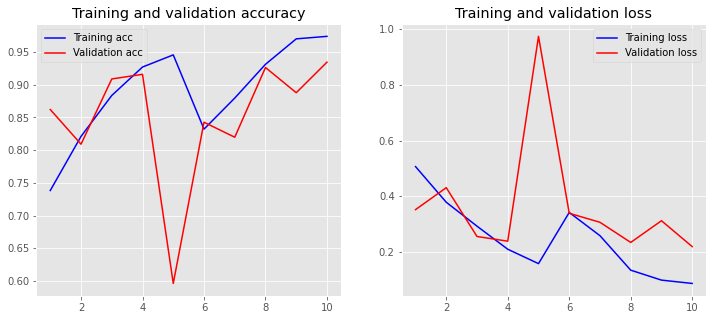

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


#call the function using history
plot_history(history)

A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

Note: When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

# 2nd RUN with embedding_dim=100 & batch_size=128

Epoch 1/10
86/86 [==============================] - 80s 928ms/step - loss: 0.0640 - accuracy: 0.9824 - val_loss: 0.2316 - val_accuracy: 0.9300
Epoch 2/10
86/86 [==============================] - 80s 928ms/step - loss: 0.0581 - accuracy: 0.9843 - val_loss: 0.2319 - val_accuracy: 0.9253
Epoch 3/10
86/86 [==============================] - 80s 925ms/step - loss: 0.0648 - accuracy: 0.9808 - val_loss: 0.1736 - val_accuracy: 0.9434
Epoch 4/10
86/86 [==============================] - 82s 955ms/step - loss: 0.0472 - accuracy: 0.9887 - val_loss: 0.2217 - val_accuracy: 0.9371
Epoch 5/10
86/86 [==============================] - 80s 930ms/step - loss: 0.0657 - accuracy: 0.9817 - val_loss: 0.2495 - val_accuracy: 0.9240
Epoch 6/10
86/86 [==============================] - 80s 929ms/step - loss: 0.0536 - accuracy: 0.9864 - val_loss: 0.1939 - val_accuracy: 0.9472
Epoch 7/10
86/86 [==============================] - 80s 933ms/step - loss: 0.0509 - accuracy: 0.9876 - val_loss: 0.3049 - val_accuracy: 0.9207

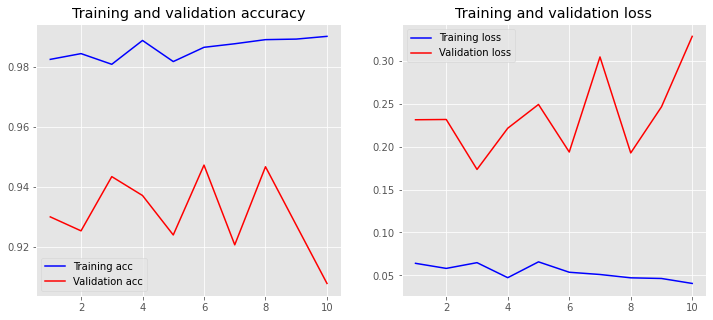

In [14]:
from keras.backend import clear_session
clear_session()

history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=128)
#compute performance
performance(x_test, y_test)

#call the function using history
plot_history(history)

# 3rd RUN & new model with embedding_dim=50, batch_size=64

Epoch 1/10
172/172 [==============================] - 75s 424ms/step - loss: 0.5779 - accuracy: 0.6694 - val_loss: 0.3624 - val_accuracy: 0.8562
Epoch 2/10
172/172 [==============================] - 75s 438ms/step - loss: 0.3375 - accuracy: 0.8628 - val_loss: 0.6366 - val_accuracy: 0.6727
Epoch 3/10
172/172 [==============================] - 72s 416ms/step - loss: 0.3055 - accuracy: 0.8583 - val_loss: 0.2665 - val_accuracy: 0.8821
Epoch 4/10
172/172 [==============================] - 71s 413ms/step - loss: 0.2119 - accuracy: 0.9161 - val_loss: 0.2464 - val_accuracy: 0.8977
Epoch 5/10
172/172 [==============================] - 72s 421ms/step - loss: 0.1551 - accuracy: 0.9398 - val_loss: 0.2630 - val_accuracy: 0.9027
Epoch 6/10
172/172 [==============================] - 73s 423ms/step - loss: 0.1874 - accuracy: 0.9348 - val_loss: 0.2159 - val_accuracy: 0.9218
Epoch 7/10
172/172 [==============================] - 73s 423ms/step - loss: 0.0946 - accuracy: 0.9708 - val_loss: 0.2404 - val_ac

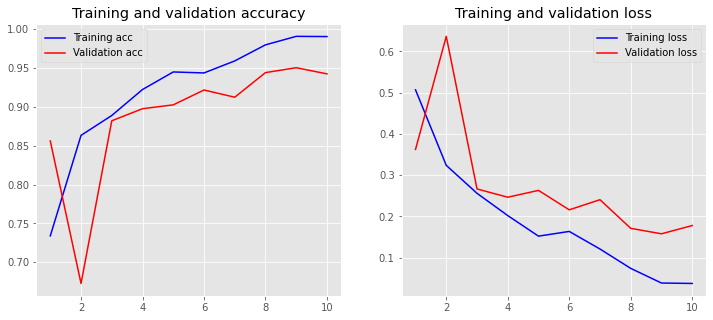

In [15]:
clear_session()

embedding_dim = 50
#build embedding matrix.
embedding_matrix = create_embedding_matrix('/content/glove.6B.50d.txt',
                                            tokenizer.word_index,  
                                            embedding_dim)

#buidl the hybrid cnn-rnn model.
model_1 = Sequential()
model_1.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model_1.add(layers.Conv1D(128, 5, activation='relu'))
model_1.add(layers.MaxPooling1D(2))
model_1.add(layers.LSTM(32))
model_1.add(layers.Dense(1, activation='sigmoid'))
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#train the model.
history_1 = model_1.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    batch_size=64)

#confusion matrix and classification report.
performance(x_test, y_test)

#call the function using history
plot_history(history_1)

######################__A MODEL CREATED BY PINTU (181CO139) AND AKSHAY DHAYAL (181CO105) __####################